In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neural_network import MLPRegressor

In [42]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# PCA features - number of qubits
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [43]:
def load_patient_data(patiend_id):
    # Loads signal and extracts heartbeats based on annotations
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('file not found')
        return [], []
    
    # Loads patient ECG signal, extracting the MLII column
    df_ekg = pd.read_csv(ekg_file)
    # Strips spaces from column names (common CSV issue)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # If names are missing, use index 1 (0 is usually time/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Clean names
            
        # Locate relevant columns (sample = position, symbol = type)
        # Names may vary ('sample', 'Sample', 'time', etc.)
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Column 'sample' or 'symbol' in annotations not found.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Skip heartbeats at the beginning or end of the recording
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Extract segment
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Ensure exact length
        if len(window) != WINDOW_SIZE:
            continue

        # Classification
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Found: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> STEP 1: Loading training data (Healthy)...
  -> Found: 600 Normal, 34 Anomaly
  -> Found: 600 Normal, 3 Anomaly
  -> Found: 99 Normal, 600 Anomaly

>>> STEP 2: Loading test data (Mixed)...
  -> Found: 600 Normal, 520 Anomaly
  -> Found: 600 Normal, 444 Anomaly

RAW DATA STATUS:
Single beat dimension: 90 samples
Number of Train samples (Normal): 1299
Number of Test samples (Normal): 1200
Number of Test samples (Anomaly): 964

>>> STEP 3: Dimensionality reduction (PCA) from 90 to 8...
Explained variance (how much info we kept): 99.48%
>>> STEP 4: Scaling to (0, pi) range...
Saved PCA and scaler to file: preprocessing_8dim.joblib

>>> STEP 5: Saving .npy files...
DONE! You can now run the Qiskit script.

>>> Generating control plot...


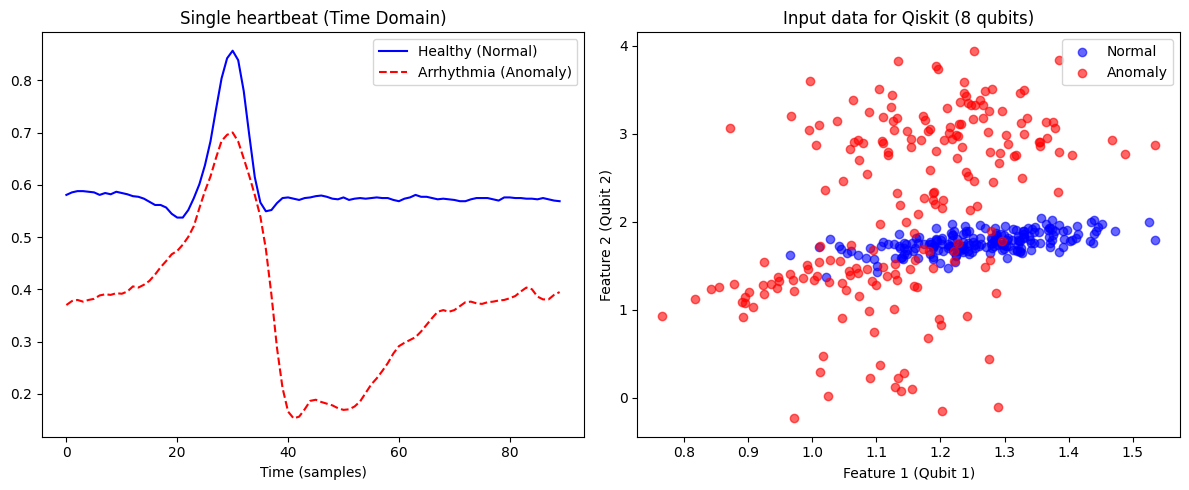

In [44]:
# --- DATA COLLECTION ---
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> STEP 1: Loading training data (Healthy)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> STEP 2: Loading test data (Mixed)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Convert to numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nRAW DATA STATUS:")
print(f"Single beat dimension: {WINDOW_SIZE} samples")
print(f"Number of Train samples (Normal): {X_train.shape[0]}")
print(f"Number of Test samples (Normal): {X_test_normal.shape[0]}")
print(f"Number of Test samples (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("CRITICAL ERROR: No training data. Check the CSV filenames!")
    raise ValueError

# --- # PROCESSING (PCA) ---
print(f"\n>>> STEP 3: Dimensionality reduction (PCA) from {WINDOW_SIZE} to {N_DIM}...")

# 1. Fit PCA only on healthy training data
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# 2. Transform all datasets
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# 3. Handle case with no anomalies to prevent crashes
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Explained variance (how much info we kept): {sum(pca.explained_variance_ratio_):.2%}")

# --- QUANTUM SCALING ---
# Qiskit prefers data in (0, pi) or (-1, 1) range.
# We use (0, pi) for rotation gates.
print(">>> STEP 4: Scaling to (0, pi) range...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Fit scaler on training data

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "ibm_preprocessing_8dim.joblib"
)
print("Saved PCA and scaler to file: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# --- SAVING ---
print("\n>>> STEP 5: Saving .npy files...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("DONE! You can now run the Qiskit script.")

# --- VISUALIZATION ---
print("\n>>> Generating control plot...")
plt.figure(figsize=(12, 5))

# Plot 1: Raw heartbeat visualization
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Healthy (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arrhythmia (Anomaly)', color='red', linestyle='--')
plt.title("Single heartbeat (Time Domain)")
plt.xlabel("Time (samples)")
plt.legend()

# Plot 2: Post-PCA visualization
plt.subplot(1, 2, 2)
# Plot only 100 points for readability
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Input data for Qiskit ({N_DIM} qubits)")
plt.xlabel("Feature 1 (Qubit 1)")
plt.ylabel("Feature 2 (Qubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

>>> START: CLASSICAL AUTOENCODER (Input: 8 -> Hidden: 4 -> Output: 8)
    Training on: 600 samples
    Training data: (600, 8)
>>> Neural Network Training...
    Training finished.
    Final Loss: 0.043879


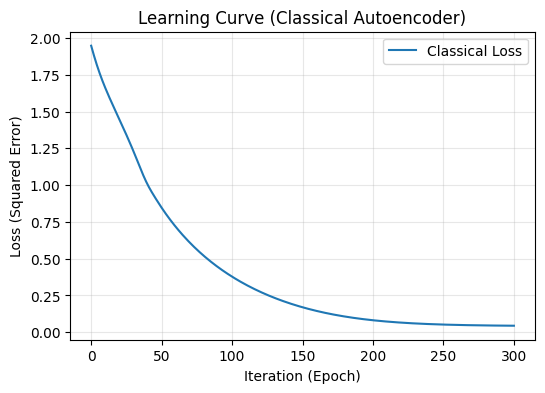

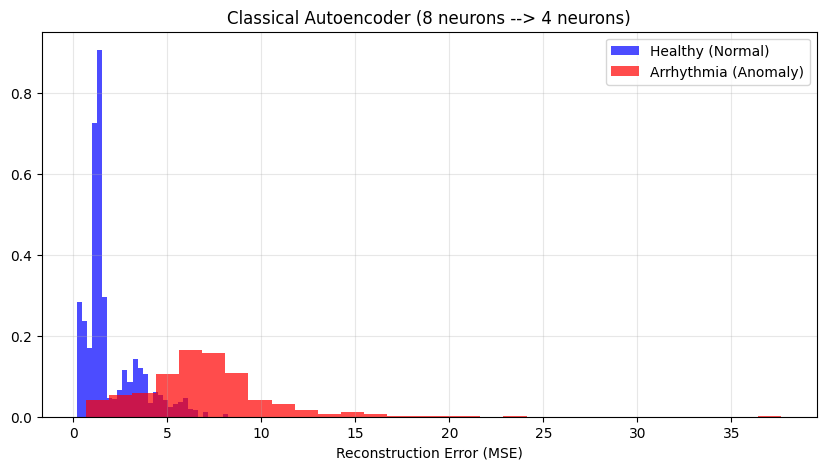


>>> Determined Cut-off Threshold: 4.3968
>>> FINAL RESULTS (CLASSICAL):
    ACCURACY: 86.88%


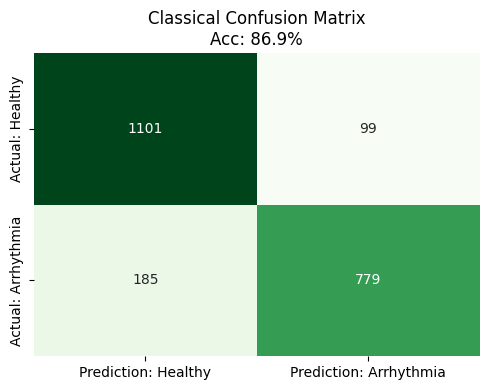

In [45]:
# --- CONFIGURATION (Same as in Quantum) ---
INPUT_DIM = 8       # Equivalent to 8 qubits
HIDDEN_DIM = 4      # Compression equivalent
LIMIT_SAMPLES = 600 # Change to 100, 300, 600 in subsequent tests

print(f">>> START: CLASSICAL AUTOENCODER (Input: {INPUT_DIM} -> Hidden: {HIDDEN_DIM} -> Output: {INPUT_DIM})")

# 1. Loading Data
try:
    train_data = np.load('train_data.npy')[:LIMIT_SAMPLES]
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("ERROR: .npy files missing! Run prepare_data.py")
    exit()

print(f"    Training on: {len(train_data)} samples")
print(f"    Training data: {train_data.shape}")

# 2. Classical Model (MLP)
# Architecture: Input(8) -> Hidden(4) -> Output(8)
# 'tanh' activation is closest to quantum gates (-1 to 1 range)
# 'adam' solver matches the optimizer used in deep networks
autoencoder = MLPRegressor(
    hidden_layer_sizes=(HIDDEN_DIM,), 
    activation='tanh', 
    solver='adam', 
    max_iter=1000, 
    random_state=42
)

# 3. Training (X -> X)
# In an autoencoder, input (X) is also the target (Y). The network must reconstruct the input.
print(">>> Neural Network Training...")
autoencoder.fit(train_data, train_data)
print("    Training finished.")
print(f"    Final Loss: {autoencoder.loss_curve_[-1]:.6f}")

# TRAINING PROCESS VISUALIZATION (LOSS)
plt.figure(figsize=(6, 4))
plt.plot(autoencoder.loss_curve_, label='Classical Loss')
plt.title("Learning Curve (Classical Autoencoder)")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Loss (Squared Error)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig(f"result_images/classical_loss_{HIDDEN_DIM}latent.png")

# 4. Evaluation (Compute reconstruction error: MSE)
def get_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    # Error is the mean of squared differences between input and output
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

mse_normal = get_reconstruction_error(test_normal)
mse_anomaly = get_reconstruction_error(test_anomaly)

# 5. Histogram visualization (Compare with IBM plot!)
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=30, alpha=0.7, color='blue', label='Healthy (Normal)', density=True)
plt.hist(mse_anomaly, bins=30, alpha=0.7, color='red', label='Arrhythmia (Anomaly)', density=True)
plt.title(f"Classical Autoencoder (8 neurons --> 4 neurons)")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f"result_images/classical_histogram_{HIDDEN_DIM}latent.png")
plt.show()

# ==========================================
# 6. CALCULATING ACCURACY (Classification)
# ==========================================
# We need to find the threshold that best separates the peaks
# In classical models, arrhythmia USUALLY has a LARGER error (on the right)

# Automatic threshold search (mean between the means of both distributions)
threshold = (np.mean(mse_normal) + np.mean(mse_anomaly)) / 2
print(f"\n>>> Determined Cut-off Threshold: {threshold:.4f}")

# Classification:
# 0 = Healthy (Error < Threshold)
# 1 = Arrhythmia (Error > Threshold)
# NOTE: Here logic is "normal" (large error = disease).
# In quantum you can have "inversion". Here it likely won't be present.

y_pred_norm = [1 if e > threshold else 0 for e in mse_normal]
y_pred_anom = [1 if e > threshold else 0 for e in mse_anomaly]

y_true = [0] * len(mse_normal) + [1] * len(mse_anomaly)
y_pred = y_pred_norm + y_pred_anom

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f">>> FINAL RESULTS (CLASSICAL):")
print(f"    ACCURACY: {acc:.2%}")

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Prediction: Healthy', 'Prediction: Arrhythmia'],
            yticklabels=['Actual: Healthy', 'Actual: Arrhythmia'])
plt.title(f'Classical Confusion Matrix\nAcc: {acc:.1%}')
plt.tight_layout()
plt.savefig(f"result_images/classical_confusion_matrix_{HIDDEN_DIM}latent.png")
plt.show()

>>> AUC (Area Under Curve): 0.9335


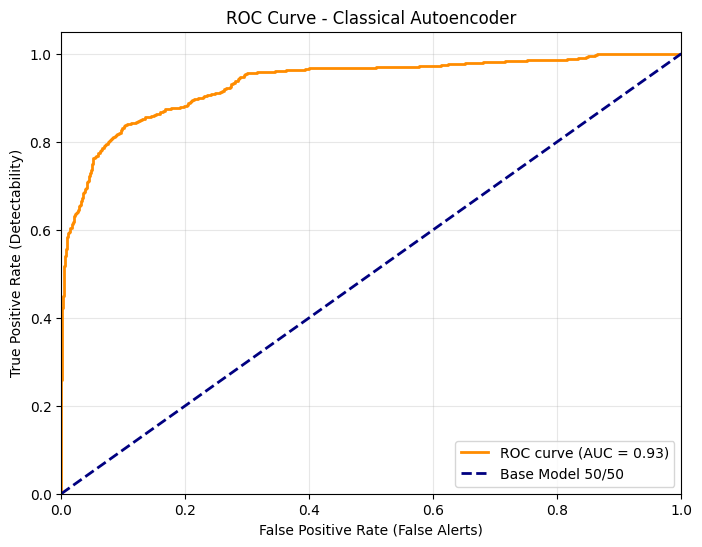

In [46]:
# --- 1. Data Preparation for ROC ---
# Need to combine the results into a single long vector
y_scores = np.concatenate([mse_normal, mse_anomaly])

# We need to create a vector of true labels (0 = Healthy, 1 = Arrhythmia)
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomaly))])

# --- 2. Calculate ROC Curve ---
# The function returns:
# fpr = False Positive Rate (How many times we falsely triggered an alarm)
# tpr = True Positive Rate (How many times we correctly detected the disease)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# --- 3. Calculate AUC (Area Under Curve) ---
# This is the single number you put in the table (e.g., 0.95)
roc_auc = auc(fpr, tpr)
print(f">>> AUC (Area Under Curve): {roc_auc:.4f}")

# --- 4. Drawing the Plot ---
plt.figure(figsize=(8, 6))

# Draw the model curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Draw the random guess line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Base Model 50/50')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alerts)')
plt.ylabel('True Positive Rate (Detectability)')
plt.title('ROC Curve - Classical Autoencoder')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig(f"result_images/classical_roc_curve_{HIDDEN_DIM}latent.png")
plt.show()

>>> START: CLASSICAL AUTOENCODER (Input: 8 -> Hidden: 2 -> Output: 8)
    Training on: 600 samples
    Training data: (600, 8)
>>> Neural Network Training...
    Training finished.
    Final Loss: 0.046667


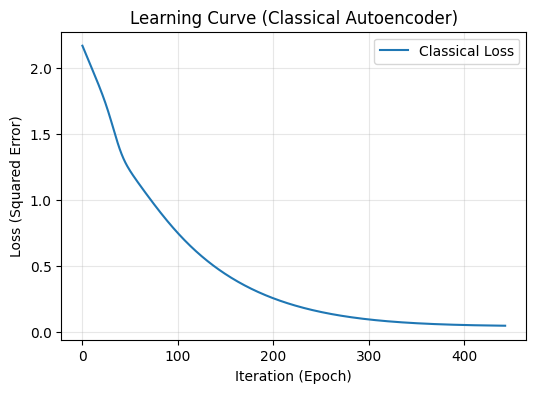

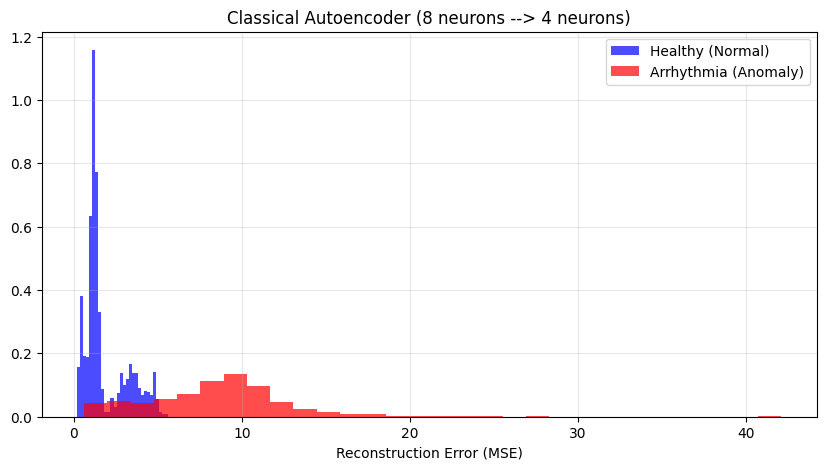


>>> Determined Cut-off Threshold: 5.1338
>>> FINAL RESULTS (CLASSICAL):
    ACCURACY: 90.34%


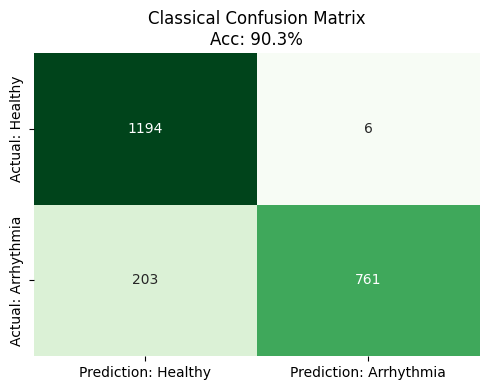

In [47]:
# --- CONFIGURATION (Same as in Quantum) ---
INPUT_DIM = 8       # Equivalent to 8 qubits
HIDDEN_DIM = 2      # Compression equivalent
LIMIT_SAMPLES = 600 # Change to 100, 300, 600 in subsequent tests

print(f">>> START: CLASSICAL AUTOENCODER (Input: {INPUT_DIM} -> Hidden: {HIDDEN_DIM} -> Output: {INPUT_DIM})")

# 1. Loading Data
try:
    train_data = np.load('train_data.npy')[:LIMIT_SAMPLES]
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("ERROR: .npy files missing! Run prepare_data.py")
    exit()

print(f"    Training on: {len(train_data)} samples")
print(f"    Training data: {train_data.shape}")

# 2. Classical Model (MLP)
# Architecture: Input(8) -> Hidden(4) -> Output(8)
# 'tanh' activation is closest to quantum gates (-1 to 1 range)
# 'adam' solver matches the optimizer used in deep networks
autoencoder = MLPRegressor(
    hidden_layer_sizes=(HIDDEN_DIM,), 
    activation='tanh', 
    solver='adam', 
    max_iter=1000, 
    random_state=42
)

# 3. Training (X -> X)
# In an autoencoder, input (X) is also the target (Y). The network must reconstruct the input.
print(">>> Neural Network Training...")
autoencoder.fit(train_data, train_data)
print("    Training finished.")
print(f"    Final Loss: {autoencoder.loss_curve_[-1]:.6f}")

# TRAINING PROCESS VISUALIZATION (LOSS)
plt.figure(figsize=(6, 4))
plt.plot(autoencoder.loss_curve_, label='Classical Loss')
plt.title("Learning Curve (Classical Autoencoder)")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Loss (Squared Error)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig(f"result_images/classical_loss_{HIDDEN_DIM}_latent.png")

# 4. Evaluation (Compute reconstruction error: MSE)
def get_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    # Error is the mean of squared differences between input and output
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

mse_normal = get_reconstruction_error(test_normal)
mse_anomaly = get_reconstruction_error(test_anomaly)

# 5. Histogram visualization (Compare with IBM plot!)
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=30, alpha=0.7, color='blue', label='Healthy (Normal)', density=True)
plt.hist(mse_anomaly, bins=30, alpha=0.7, color='red', label='Arrhythmia (Anomaly)', density=True)
plt.title(f"Classical Autoencoder (8 neurons --> 4 neurons)")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f"result_images/classical_histogram_{HIDDEN_DIM}latent.png")
plt.show()

# ==========================================
# 6. CALCULATING ACCURACY (Classification)
# ==========================================
# We need to find the threshold that best separates the peaks
# In classical models, arrhythmia USUALLY has a LARGER error (on the right)

# Automatic threshold search (mean between the means of both distributions)
threshold = (np.mean(mse_normal) + np.mean(mse_anomaly)) / 2
print(f"\n>>> Determined Cut-off Threshold: {threshold:.4f}")

# Classification:
# 0 = Healthy (Error < Threshold)
# 1 = Arrhythmia (Error > Threshold)
# NOTE: Here logic is "normal" (large error = disease).
# In quantum you can have "inversion". Here it likely won't be present.

y_pred_norm = [1 if e > threshold else 0 for e in mse_normal]
y_pred_anom = [1 if e > threshold else 0 for e in mse_anomaly]

y_true = [0] * len(mse_normal) + [1] * len(mse_anomaly)
y_pred = y_pred_norm + y_pred_anom

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f">>> FINAL RESULTS (CLASSICAL):")
print(f"    ACCURACY: {acc:.2%}")

# Macierz Pomyłek
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Prediction: Healthy', 'Prediction: Arrhythmia'],
            yticklabels=['Actual: Healthy', 'Actual: Arrhythmia'])
plt.title(f'Classical Confusion Matrix\nAcc: {acc:.1%}')
plt.tight_layout()
plt.savefig(f"result_images/classical_confusion_matrix_{HIDDEN_DIM}latent.png")
plt.show()

>>> AUC (Area Under Curve): 0.9480


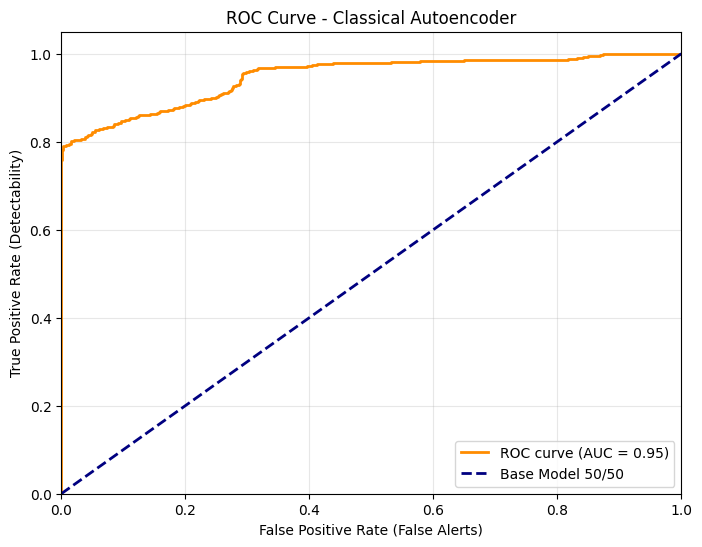

In [48]:
# --- 1. Data Preparation for ROC ---
# Need to combine the results into a single long vector
y_scores = np.concatenate([mse_normal, mse_anomaly])

# We need to create a vector of true labels (0 = Healthy, 1 = Arrhythmia)
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomaly))])

# --- 2. Calculate ROC Curve ---
# The function returns:
# fpr = False Positive Rate (How many times we falsely triggered an alarm)
# tpr = True Positive Rate (How many times we correctly detected the disease)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# --- 3. Calculate AUC (Area Under Curve) ---
# This is the single number you put in the table (e.g., 0.95)
roc_auc = auc(fpr, tpr)
print(f">>> AUC (Area Under Curve): {roc_auc:.4f}")

# --- 4. Drawing the Plot ---
plt.figure(figsize=(8, 6))

# Draw the model curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Draw the random guess line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Base Model 50/50')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alerts)')
plt.ylabel('True Positive Rate (Detectability)')
plt.title('ROC Curve - Classical Autoencoder')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig(f"result_images/classical_roc_curve_{HIDDEN_DIM}latent.png")
plt.show()